In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import oceanspy as ospy
ecco = ospy.open_oceandataset.from_catalog('ECCO')

# This is not necessary. It is certainly faster if you have maskU and maskV at hand, 
# say from the shared notebook/analytical folder. 
# ecco._ds['maskU'] = ecco._ds['maskC']
# ecco._ds['maskU'].values = np.load('maskU.npy')
# ecco._ds['maskV'] = ecco._ds['maskC']
# ecco._ds['maskV'].values = np.load('maskV.npy')

Opening ECCO.
ECCO v4r4 3D dataset, ocean simulations on LLC90 grid


In [3]:
import OceInterp as oi

In [4]:
oi.rcParam['debug_level'] = 'very_high'
# 'high','very_high','not that high'

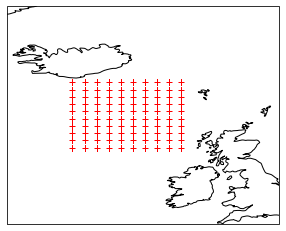

(100,)

In [5]:
import cartopy.crs as ccrs
# change the number of particles here
N = int(1e2)
# change the vertical depth of the particles here
levels = np.array([-5])
sqrtN = int(np.sqrt(N))
x = np.linspace(-19,-9,sqrtN)
y = np.linspace(63,57,sqrtN)

x,y = np.meshgrid(x,y)
ax = plt.axes(projection = ccrs.PlateCarree())
ax.plot(x,y,'r+')
ax.coastlines()
ax.set_xlim([-25,0])
ax.set_ylim([50,70])
plt.show()

small_shape = x.shape
x = x.ravel()
y = y.ravel()

x,z = np.meshgrid(x,levels)
y,z = np.meshgrid(y,levels)

x = x.ravel()
y = y.ravel()
z = z.ravel()

# t = np.array([np.datetime64('2000-01') for i in range(len(x))])
# t = (t-od._ds['time'][0].values).astype(float)
start_time = '1998-12-15'
t = (np.array([np.datetime64(start_time) for i in x])
     -np.datetime64('1970-01-01'))/np.timedelta64(1, 's')

t.shape

In [6]:
help(oi.OceInterp)

Help on function OceInterp in module OceInterp.OceInterp:

OceInterp(od, varList, x, y, z, t, kernelList=None, lagrangian=False, lagrange_kwarg={}, update_stops='default', return_in_between=True, return_pt_time=True, **kernel_kwarg)
    The center piece function of the package, from here 
    you can access almost all the functionality of the 
    package.
    -------
    od: OceInterp.OceData object or xarray.Dataset (hopefully also netcdf)
        the dataset to work on
    varList: str or lst
        (list of) variable/pair of variables
    kernelList: OceInterp.KnW/list of OceInterp.KnW object
        which kernel to use for each interpolation
    x,y,z: numpy.ndarray
        location of the particles, x,y are in degrees, and 
        z are in meters, the deeper, the more negative. 
    t: numpy.ndarray
        In Eulerian scheme, the time of interpolation.
        In Lagrangian scheme, the time needed for output. 
    lagrangian: bool
        whether the interpolation is done in E

In [7]:
[s,[u,v],eta,mask] = oi.OceInterp(ecco._ds,['SALT',['UVELMASS','VVELMASS'],'ETAN','maskC'],x,y,z,t)

Creating new weight function, the first time is going to be slow
Creating new weight function, the first time is going to be slow
creating maskU, this is going to be slow!
creating maskV, this is going to be slow!


Text(0.5, 1.0, 'Salinity (psu)')

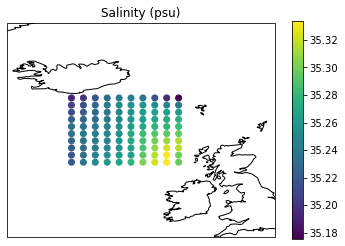

In [8]:
ax = plt.axes(projection = ccrs.PlateCarree())
c = ax.scatter(x,y,c = s)
ax.coastlines()
ax.set_xlim([-25,0])
ax.set_ylim([50,70])
plt.colorbar(c)
plt.title('Salinity (psu)')

Text(0.5, 1.0, 'Zonal Velocity (m/s)')

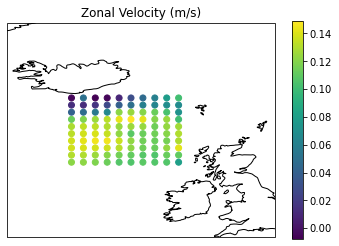

In [9]:
ax = plt.axes(projection = ccrs.PlateCarree())
c = ax.scatter(x,y,c = u)
ax.coastlines()
ax.set_xlim([-25,0])
ax.set_ylim([50,70])
plt.colorbar(c)
plt.title('Zonal Velocity (m/s)')

Text(0.5, 1.0, 'Sea Surface Height (m)')

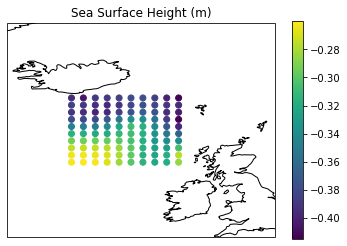

In [10]:
ax = plt.axes(projection = ccrs.PlateCarree())
c = ax.scatter(x,y,c = eta)
ax.coastlines()
ax.set_xlim([-25,0])
ax.set_ylim([50,70])
plt.colorbar(c)
plt.title('Sea Surface Height (m)')

In [11]:
start_time = '1998-12-15'
end_time = '1998-09'

t_bnds = np.array([
    np.datetime64(start_time)-np.datetime64('1970-01-01'),
    np.datetime64(  end_time)-np.datetime64('1970-01-01')
])/np.timedelta64(1, 's')

In [12]:
t_bnds

array([9.13680e+08, 9.04608e+08])

In [13]:
stops,[s,raw,lat,lon] = oi.OceInterp(ecco._ds,
                                 ['SALT','__particle.raw','__particle.lat','__particle.lon'],
                                 x,y,z,t_bnds,
                                lagrangian = True,
                                     return_pt_time = True,
                                     lagrange_kwarg={'save_raw':True}
                                     # this is actually default to be True
                                    )

creating maskWvel, this is going to be slow!

1998-12-01T06:00:00
100 left 98 left 91 left 63 left 16 left 
1998-10-31T18:00:00
100 left 100 left 100 left 100 left 95 left 82 left 66 left 35 left 5 left 
1998-10-01T06:00:00
100 left 100 left 96 left 84 left 77 left 50 left 17 left 2 left 
1998-09-01T00:00:00
100 left 90 left 66 left 32 left 11 left 1 left 

In [14]:
stops

(912492000.0, 909856800.0, 907221600.0, 904608000.0)

Text(0.5, 1.0, 'salinity map')

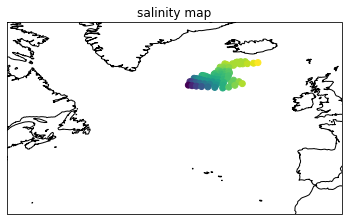

In [15]:
ax = plt.axes(projection = ccrs.PlateCarree())
ax.scatter(lon[-1],lat[-1],c = s[-1])
ax.coastlines()
ax.set_xlim([-70,0])
ax.set_ylim([30,70])
plt.title('salinity map')

In [16]:
raw

## other classes
### 1. kernel object

In [17]:
KnW = oi.kernelNweight.KnW

In [18]:
default = KnW()
dz_kernel = KnW(vkernel = 'dz')
dx2_kernel = KnW(hkernel = 'dx',h_order = 2,inheritance = [[0,1,2,3,4,5,6,7,8]],tkernel = 'linear')
dt_kernel = KnW(tkernel = 'dt')

Creating new weight function, the first time is going to be slow


In [19]:
output = oi.OceInterp(ecco._ds,{'SALT':dz_kernel,('UVELMASS','VVELMASS'):(dx2_kernel,dt_kernel)},x,y,z,t)

result will be in the order of ['SALT', ('UVELMASS', 'VVELMASS')]


In [20]:
[dsdz,[d2udx2,dvdt]] = output

Text(0.5, 1.0, 'Second Derivative of the Zonal Velocity (m/s per grid scale squared)')

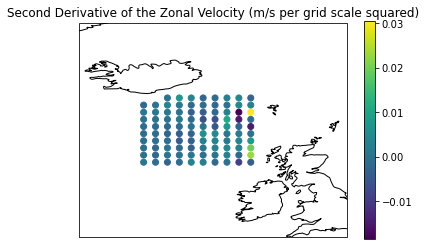

In [21]:
ax = plt.axes(projection = ccrs.PlateCarree())
c = ax.scatter(x,y,c = d2udx2)
ax.coastlines()
ax.set_xlim([-25,0])
ax.set_ylim([50,70])
plt.colorbar(c)
plt.title('Second Derivative of the Zonal Velocity (m/s per grid scale squared)')